# Reset variables

In [1]:
%reset -f

# Overview of studies


In [2]:
import pydicom

# Load DICOMDIR file
dicomdir_path = "./data/Gent_-_AZ_Jan-Palfijn_-_R240503085_01/DICOMDIR"
dicomdir = pydicom.dcmread(dicomdir_path)

# Loop through the records
for record in dicomdir.DirectoryRecordSequence:
    if record.DirectoryRecordType == "PATIENT":
        print(f"Patient ID: {record.PatientID}")

    elif record.DirectoryRecordType == "STUDY":
        print(f"  Study: {record.StudyInstanceUID}")

    elif record.DirectoryRecordType == "SERIES":
        print(f"    Series: {record.SeriesInstanceUID}")

    elif record.DirectoryRecordType == "IMAGE":
        print(f"      Image File: {record.ReferencedFileID}")


Patient ID: 9903238260
  Study: 1.2.840.113619.2.416.9850619609916121837733089474120576245
    Series: 1.2.840.113619.2.416.236389159052507511560076503794002259002
      Image File: ['DICOM', '000000']
      Image File: ['DICOM', '000001']
    Series: 1.2.840.113619.2.416.198006877293753569037624863769095891603
      Image File: ['DICOM', '000002']
    Series: 1.2.840.113619.2.416.161422774137400886388032432367134223020
      Image File: ['DICOM', '000003']
      Image File: ['DICOM', '000004']
      Image File: ['DICOM', '000005']
      Image File: ['DICOM', '000006']
      Image File: ['DICOM', '000007']
      Image File: ['DICOM', '000008']
      Image File: ['DICOM', '000009']
      Image File: ['DICOM', '000010']
      Image File: ['DICOM', '000011']
      Image File: ['DICOM', '000012']
      Image File: ['DICOM', '000013']
      Image File: ['DICOM', '000014']
      Image File: ['DICOM', '000015']
      Image File: ['DICOM', '000016']
      Image File: ['DICOM', '000017']
      

# Investigating attributes

Investigating attributes of one dicom image

In [3]:
import pydicom
import os
import numpy as np

dicom_folder = "./data/Gent_-_AZ_Jan-Palfijn_-_R240503085_01/DICOM/"
# Get the first file in the directory
first_file = sorted(os.listdir(dicom_folder))[0]
dicom_path = os.path.join(dicom_folder, first_file)

# Read the DICOM file
ds = pydicom.dcmread(dicom_path)

# Print all available keys (DICOM tags)
print("Available DICOM attributes:\n")
for elem in ds.dir():
    print(elem)


Available DICOM attributes:

AccessionNumber
AcquisitionDate
AcquisitionNumber
AcquisitionTime
AdditionalPatientHistory
BitsAllocated
BitsStored
BodyPartExamined
Columns
ContentDate
ContentTime
ConvolutionKernel
DataCollectionDiameter
DeviceSerialNumber
DistanceSourceToDetector
DistanceSourceToPatient
Exposure
ExposureInuAs
ExposureTime
FilterType
FocalSpots
FrameOfReferenceUID
GantryDetectorTilt
GeneratorPower
HighBit
ImageOrientationPatient
ImagePositionPatient
ImageType
InstanceCreationDate
InstanceCreationTime
InstanceNumber
InstitutionName
IrradiationEventUID
KVP
Manufacturer
ManufacturerModelName
Modality
NameOfPhysiciansReadingStudy
NumberOfFrames
OperatorsName
OtherPatientIDs
OtherPatientIDsSequence
PatientAge
PatientBirthDate
PatientID
PatientName
PatientPosition
PatientSex
PatientSize
PatientWeight
PerformedProcedureStepDescription
PerformedProcedureStepID
PerformedProcedureStepStartDate
PerformedProcedureStepStartTime
PerformingPhysicianName
PhotometricInterpretation
PixelDa

# Load all DICOM images

In [4]:
def load_dicom_series(folder):
    slices = []
    for filename in sorted(os.listdir(folder)):  
        filepath = os.path.join(folder, filename)
        ds = pydicom.dcmread(filepath)

        # Skip non-image files
        if ds.Modality != "CT" or "PixelData" not in ds:
            continue
        if hasattr(ds, "ImagePositionPatient"):
            image_type = ds.get('ImageType')
            if image_type[0] == "ORIGINAL":
                print(f"{filename}: Modality = {ds.Modality}, ImageType = {ds.get('ImageType')}")
            else:
                continue
        
        slices.append(ds)
    
    return slices

dicom_slices = load_dicom_series(dicom_folder)
print(f"Loaded {len(dicom_slices)} valid CT slices.")


000000: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY', 'LOCALIZER']
000001: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY', 'LOCALIZER']
000003: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY', 'AXIAL', 'GSI MONO']
000004: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY', 'AXIAL', 'GSI MONO']
000005: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY', 'AXIAL', 'GSI MONO']
000006: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY', 'AXIAL', 'GSI MONO']
000007: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY', 'AXIAL', 'GSI MONO']
000008: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY', 'AXIAL', 'GSI MONO']
000009: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY', 'AXIAL', 'GSI MONO']
000010: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY', 'AXIAL', 'GSI MONO']
000011: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY', 'AXIAL', 'GSI MONO']
000012: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY', 'AXIAL', 'GSI MONO']
000013: Modality = CT, ImageType = ['ORIGINAL', 'PRIMARY

# Find good slices

Manually inspecting the data reveals that slices 3 to 997 are the ones we want

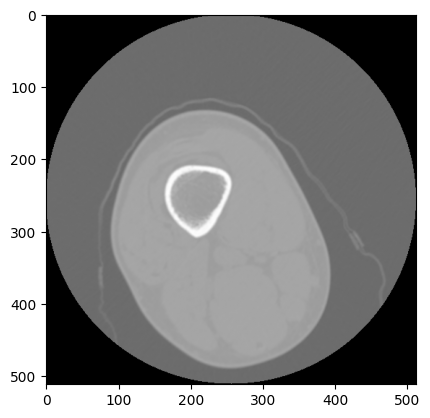

In [5]:
import matplotlib.pyplot as plt

img = dicom_slices[20]
plt.imshow(img.pixel_array, cmap="gray")
plt.show()

In [6]:
right_slices = dicom_slices[3:998]
len(right_slices)

995

# Get Hounsfields units
Turns slices into one three dimensional grid of HU values

In [7]:
def get_hu_values(dicom_slices):
    # Sort slices by ImagePositionPatient (important for correct stacking)
    dicom_slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    image_stack = np.stack([s.pixel_array for s in dicom_slices]).astype(np.int16)
    
    # Convert pixel values to HU
    for i, s in enumerate(dicom_slices):
        intercept = s.RescaleIntercept
        slope = s.RescaleSlope
        image_stack[i] = slope * image_stack[i] + intercept

    return image_stack

hu_volume = get_hu_values(right_slices)


In [8]:
def get_spacing(dicom_slices):
    pixel_spacing = dicom_slices[0].PixelSpacing  # [row_spacing, col_spacing]
    slice_thickness = getattr(dicom_slices[0], "SliceThickness", None)
    spacing_between_slices = getattr(dicom_slices[0], "SpacingBetweenSlices", None)
    # Use SpacingBetweenSlices if it makes more sense
    slice_thickness = spacing_between_slices

    return np.array([slice_thickness, pixel_spacing[0], pixel_spacing[1]])

voxel_size = get_spacing(dicom_slices)

print(f"\nVoxel Size (mm):\n"
      f"  Slice Thickness: {voxel_size[0]:.2f} mm\n"
      f"  Pixel Spacing (Row): {voxel_size[1]:.2f} mm\n"
      f"  Pixel Spacing (Column): {voxel_size[2]:.2f} mm")



Voxel Size (mm):
  Slice Thickness: 10.00 mm
  Pixel Spacing (Row): 0.64 mm
  Pixel Spacing (Column): 0.65 mm


**Note:** The slice thickness is probably wrong, it is more likely that the resolution is 0.64mm in all dimensions

In [9]:
np.save("data/ct_scan_grid.npy", hu_volume)
